In [1]:
import sys
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
import math
sys.path.append("..")

import torch

# from algorithms.deepinversion import distill_deep_inversion
# from algorithms.vanilla_distillation import distill
from distillation import run_distillation

from trainer import Trainer
from models import SimpleConvNet, SimpleResNet, Generator
from utils import get_cifar100_loader, get_cifar10_loader

device = "cuda"

%load_ext autoreload
%autoreload 2

### Init convolutional networks for teacher and students 

In [2]:
teacher = SimpleResNet(n_blocks=4, n_filters=16, input_shape=(3, 32, 32), n_classes=10).to(device)
student_reference = SimpleConvNet(n_layers=2, n_filters=16, input_shape=(3, 32, 32), n_classes=10).to(device)

student_vanilla = SimpleConvNet(n_layers=2, n_filters=16, input_shape=(3, 32, 32), n_classes=10).to(device)
student_deepinversion = SimpleConvNet(n_layers=2, n_filters=32, input_shape=(3, 32, 32), n_classes=10).to(device)
student_dfad = SimpleConvNet(n_layers=2, n_filters=32, input_shape=(3, 32, 32), n_classes=10).to(device)
student_spec_features = SimpleConvNet(n_layers=2, n_filters=32, input_shape=(3, 32, 32), n_classes=10).to(device)
student_stat_features = SimpleConvNet(n_layers=2, n_filters=32, input_shape=(3, 32, 32), n_classes=10).to(device)

### Teacher and reference student train config 

In [3]:
train_config = {
    'lr': 1e-3,
    'batch_size': 512,
    'max_iters': -1,
    'max_epochs': 8,
    'evaluate_every': 36,
    'log_every': 36,
    "optimizer": "AdamW",
    'verbose': False,
    'dataset_size': 50000
}

### Train teacher 

In [4]:
trainer = Trainer(train_config=train_config)

In [5]:
teacher = trainer.train(
    model=teacher,
    train_loader=get_cifar10_loader(data_path="../../data", train=True, batch_size=train_config["batch_size"]),
    val_loader=get_cifar10_loader(data_path="../../data", train=False, batch_size=train_config["batch_size"]),
    max_epochs=train_config["max_epochs"] // 4 # just to prevent overfitting
)
trainer.train_config["max_epochs"] = trainer.train_config["max_epochs"] * 4

Training iters:   0%|          | 0/100000 [00:00<?, ?it/s]

eval batch:   0%|          | 0/20 [00:00<?, ?it/s]

eval batch:   0%|          | 0/20 [00:00<?, ?it/s]

eval batch:   0%|          | 0/20 [00:00<?, ?it/s]

eval batch:   0%|          | 0/20 [00:00<?, ?it/s]

### Get teacher accuracy for reference 

In [6]:
trainer.evaluate(
    get_cifar10_loader(data_path="../../data", train=False, batch_size=train_config["batch_size"]),
    model=teacher
)

eval batch:   0%|          | 0/20 [00:00<?, ?it/s]

{'Accuracy': 0.6052}

### Same with refernce student (smaller network, just to see if distillation helps)

In [7]:
student_reference = trainer.train(
    model=student_reference,
    train_loader=get_cifar10_loader(data_path="../../data", train=True, batch_size=train_config["batch_size"]),
    val_loader=get_cifar10_loader(data_path="../../data", train=False, batch_size=train_config["batch_size"])
)

Training iters:   0%|          | 0/400000 [00:00<?, ?it/s]

eval batch:   0%|          | 0/20 [00:00<?, ?it/s]

eval batch:   0%|          | 0/20 [00:00<?, ?it/s]

eval batch:   0%|          | 0/20 [00:00<?, ?it/s]

eval batch:   0%|          | 0/20 [00:00<?, ?it/s]

eval batch:   0%|          | 0/20 [00:00<?, ?it/s]

eval batch:   0%|          | 0/20 [00:00<?, ?it/s]

eval batch:   0%|          | 0/20 [00:00<?, ?it/s]

eval batch:   0%|          | 0/20 [00:00<?, ?it/s]

eval batch:   0%|          | 0/20 [00:00<?, ?it/s]

eval batch:   0%|          | 0/20 [00:00<?, ?it/s]

eval batch:   0%|          | 0/20 [00:00<?, ?it/s]

eval batch:   0%|          | 0/20 [00:00<?, ?it/s]

eval batch:   0%|          | 0/20 [00:00<?, ?it/s]

eval batch:   0%|          | 0/20 [00:00<?, ?it/s]

eval batch:   0%|          | 0/20 [00:00<?, ?it/s]

eval batch:   0%|          | 0/20 [00:00<?, ?it/s]

In [8]:
trainer.evaluate(
    get_cifar10_loader(data_path="../../data", train=False, batch_size=train_config["batch_size"]),
    model=student_reference
)

eval batch:   0%|          | 0/20 [00:00<?, ?it/s]

{'Accuracy': 0.5409}

### Vanilla distillation that uses original dataset, just for reference 

In [9]:
student_vanilla = run_distillation(
    algorithm_name="vanilla",
    teacher=teacher,
    student=student_vanilla,
    config={
        "optimizer": torch.optim.AdamW(student_vanilla.parameters(), lr=train_config["lr"], betas=(0.8, 0.9)),
        "train_loader": get_cifar10_loader(data_path="../../data", train=True, batch_size=train_config["batch_size"]),
        "iterations": math.ceil(train_config['dataset_size'] / train_config["batch_size"]) * train_config["max_epochs"],
    }
)

[INFO] Running algorithm: vanilla
[INFO] Using arguments for 'vanilla': ['teacher', 'student', 'test_loader', 'optimizer', 'train_loader', 'iterations']


Training - 0/784 [                              ] ELP: 00:00d:\Desktop\10сем\BMM\DFDistill\.venv\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Training - 784/784 [██████████████████████████████] ELP: 00:49, accuracy: 0.5184 - 


In [10]:
trainer.evaluate(
    get_cifar10_loader(data_path="../../data", train=False, batch_size=train_config["batch_size"]),
    model=student_vanilla
)

eval batch:   0%|          | 0/20 [00:00<?, ?it/s]

{'Accuracy': 0.553}

### Adaptive deep inversion algorithm

In [11]:
student_deepinversion = run_distillation(
    algorithm_name="deepinversion",
    teacher=teacher,
    student=student_deepinversion,
    config={
        "total_iterations": train_config["dataset_size"] * train_config["max_epochs"],
        "distill_k_times": 16,
        "batch_size": 128,
        "deep_inversion_batch_size": 1024,
        "n_classes": 10,
    }
)

[INFO] Running algorithm: deepinversion
[INFO] Using arguments for 'deepinversion': ['teacher', 'student', 'total_iterations', 'distill_k_times', 'batch_size', 'deep_inversion_batch_size', 'n_classes']


d:\Desktop\10сем\BMM\DFDistill\dfdistill\demo\..\distillation.py:68: UserWarning: [WARNING] Argument 'test_loader' is not used by 'deepinversion' and will be ignored.
  warnings.warn(f"[WARNING] Argument '{key}' is not used by '{algorithm_name}' and will be ignored.")


Pipeline iters:   0%|          | 0/390 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

Getting_images:   0%|          | 0/100 [00:00<?, ?it/s]

In [12]:
trainer.evaluate(
    get_cifar10_loader(data_path="../../data", train=False, batch_size=train_config["batch_size"]),
    model=student_deepinversion
)

eval batch:   0%|          | 0/20 [00:00<?, ?it/s]

{'Accuracy': 0.1618}

##### not impressive, but at least better than random guess. Algorithm is quite sensitive to hyperparameters

### Data free distillation with statistical features

In [ ]:
student_stat_features = run_distillation(
    algorithm_name="stat_features",
    teacher=teacher,
    student=student_stat_features,
    config={
        'train_loader': get_cifar10_loader(data_path="../../data", train=True, batch_size=train_config["batch_size"]),
        'test_loader': get_cifar10_loader(data_path="../../data", train=False, batch_size=train_config["batch_size"]),
        'reconstruction_size': 10000,
        'device': 'cuda',
    }
)

In [ ]:
trainer.evaluate(
    get_cifar10_loader(data_path="../../data", train=False, batch_size=train_config["batch_size"]),
    model=student_stat_features
)

### Data free distillation with spectral features

In [ ]:
student_spec_features = run_distillation(
    algorithm_name="?????",#TODO
    teacher=teacher,
    student=student_spec_features,
    config={
        #TODO
    }
)

In [ ]:
trainer.evaluate(
    get_cifar10_loader(data_path="../../data", train=False, batch_size=train_config["batch_size"]),
    model=student_spec_features
)

### Data free adversarial distillation

In [7]:
generator = Generator(nz=256, nc=3, img_size=32).to(device)
optimizer_S = torch.optim.SGD(student_dfad.parameters(), lr=0.1, weight_decay=5e-4, momentum=0.9)
optimizer_G = torch.optim.Adam(generator.parameters(), lr=1e-3)
scheduler_S = torch.optim.lr_scheduler.MultiStepLR(optimizer_S, [100, 200], 0.1)
scheduler_G = torch.optim.lr_scheduler.MultiStepLR(optimizer_G, [100, 200], 0.1)

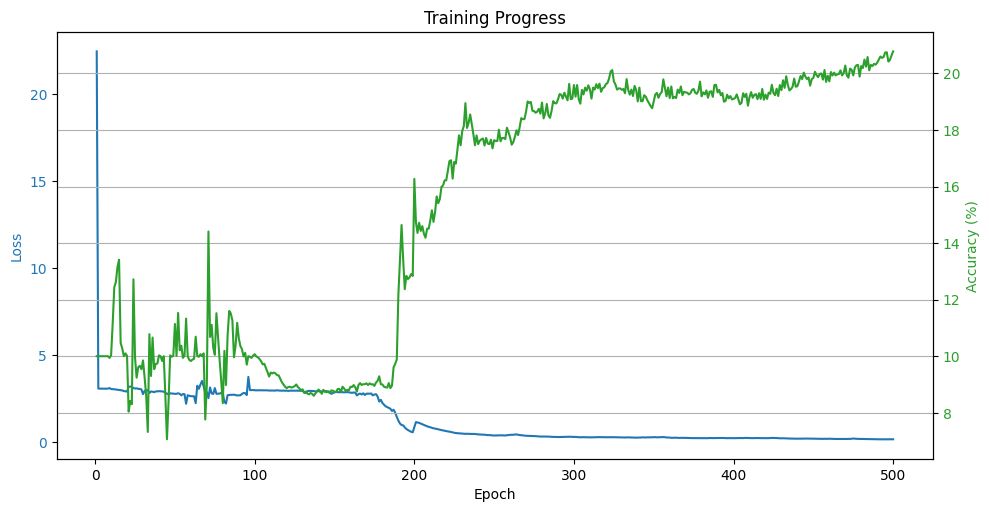


[Finished] Best Accuracy: 20.78%


In [8]:
student_dfad = run_distillation(
    algorithm_name="dfad",
    teacher=teacher,
    student=student_dfad,
    test_loader=get_cifar10_loader(data_path="../../data", train=False, batch_size=train_config["batch_size"]),
    config={
        "generator": generator,
        "optimizer_s": optimizer_S,
        "optimizer_g": optimizer_G,
        "scheduler_s": scheduler_S,
        "scheduler_g": scheduler_G
    }
)